In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from pathlib2 import Path
from PIL import Image
import time

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [29]:
# Root directory for dataset
dataroot = Path('data/h5')
#lr_dataroot = 'data/h5/lr' #might not be needed

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this size using a transformer
# modified to suit final 
hr_image_size = 256
lr_image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
# 64 by 64
nz = 4096

# Size of feature maps in generator
# starting smaller to make sure network fits
ngf = 32

# Size of feature maps in discriminator
# starting smaller to make sure network fits
ndf = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.00005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

imgextension = '.png'

In [5]:
class SatDataset():
    def __init__(self, directories, lr_transform=transforms.ToTensor(), hr_transform=transforms.ToTensor()):
        lr_images = []
        hr_images = []
        #Get all file names
        for dirName, _, fileList in os.walk(directories / 'lr_images'):
            for filename in fileList:
                if filename.endswith(imgextension):
                    lr_images.append(dirName + '/' + filename)
                    

        for idx, (dirName, _, fileList) in enumerate(os.walk(directories / 'hr_images')):
            for filename in fileList:
                if filename.endswith(imgextension):
                    hr_images.append(dirName + '/' + filename)
                    
        self.lr_images = lr_images
        self.hr_images = hr_images
        self.directories = directories
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        '''
        Returns an Image pair
        '''
        #Read image and labels
        lr_image = Image.open(self.lr_images[idx])
        hr_image = Image.open(self.hr_images[idx])

        #   Apply Defined Transformation
        lr_image = self.lr_transform(lr_image)
        hr_image = self.hr_transform(hr_image)
        return [lr_image, hr_image]

In [6]:
# directories = os.getcwd()/dataroot
# print(directories)
# directories = directories/'lr_images'
# print(directories)
# !ls -p C:\Users\georg\.fyp\data\h5\lr_images

In [7]:
#tup1 = os.walk(dataroot / 'lr_images')

In [8]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
lr_transform = transforms.Compose([transforms.Resize(lr_image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

hr_transform = transforms.Compose([transforms.Resize(hr_image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
satdataset = SatDataset(
                     os.getcwd()/dataroot, 
                     lr_transform = lr_transform, hr_transform = hr_transform
                    )

dataloader = torch.utils.data.DataLoader(
    satdataset, 
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=False
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [9]:
satdataset.__getitem__(1)[0]

tensor([[[-0.6078, -0.6157, -0.6157,  ...,  0.4667,  0.4667,  0.4902],
         [-0.5922, -0.6000, -0.6078,  ...,  0.4824,  0.4745,  0.4902],
         [-0.6314, -0.6157, -0.6157,  ...,  0.4824,  0.4824,  0.4824],
         ...,
         [-0.1216, -0.0824,  0.0196,  ..., -0.5451, -0.5843, -0.5529],
         [-0.1294, -0.0824,  0.0588,  ..., -0.5843, -0.5608, -0.5686],
         [-0.1216, -0.0196,  0.1373,  ..., -0.6157, -0.5843, -0.6078]],

        [[-0.6000, -0.6078, -0.6078,  ...,  0.4431,  0.4510,  0.4667],
         [-0.5843, -0.5922, -0.6000,  ...,  0.4510,  0.4588,  0.4667],
         [-0.6235, -0.6078, -0.6157,  ...,  0.4588,  0.4667,  0.4588],
         ...,
         [-0.1373, -0.1059, -0.0275,  ..., -0.4510, -0.5373, -0.5294],
         [-0.1451, -0.1059,  0.0196,  ..., -0.5451, -0.5373, -0.5294],
         [-0.1529, -0.0588,  0.0902,  ..., -0.5922, -0.5608, -0.5765]],

        [[-0.6157, -0.6235, -0.6235,  ...,  0.3725,  0.3725,  0.3961],
         [-0.6000, -0.6078, -0.6078,  ...,  0

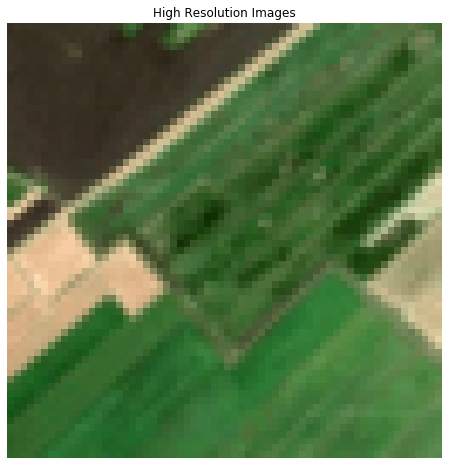

In [10]:
# Plot some training images
if __name__ == '__main__':
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("High Resolution Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0:1][0].to(device)[0], padding=2, normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


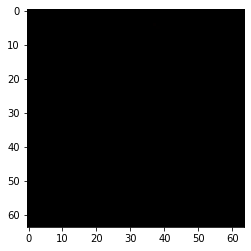

In [11]:
plt.imshow(np.transpose(real_batch[0][0]))

In [12]:
real_batch[1].shape

torch.Size([16, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


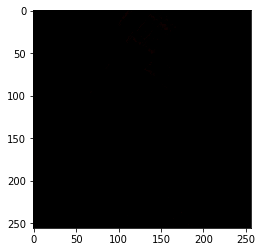

In [13]:
plt.imshow(np.transpose(real_batch[1][0]))

In [14]:
#os.getcwd()
#if u have issues with the above the dset.ImageFolder thing requires a subfolder below the path

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
#fastai implementation of skip connection... I think
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1  = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(nf)
        self.relu1  = nn.ReLU(True)
            
        self.conv2  = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(nf)
        self.relu2  = nn.ReLU(True)
            
            
    def forward(self, x): return x + self.relu2(self.bnorm2(self.conv2(self.relu1(self.bnorm1(self.conv1(x))))))

In [17]:
# Generator Code 
# This will not work without serious massage, run next block instead

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            ##change this to deal with 64*64 input
            # 3 input channels, 32 feature maps (kernels right), kernel size 9x9, , stride 1
            #64*64
            nn.Conv2d(3, 32, kernel_size = 9, stride = 1, padding=4),
            nn.PReLU(),
            # input is Z, going into a convolution
            #             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            #             nn.BatchNorm2d(ngf * 8),
            #             nn.ReLU(True),
            ResBlock(32),
            #technically should be 64*64
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(2, 3, kernel_size = 3, stride=1, padding=1),
            nn.Tanh()
            ##now we do some blocks with skip connections 
            ##skip connections pending lol
            ## umm is our feature map too big? Lets just make sure it fits in memory haha
#             nn.conv2d(32, 32, kernelsize = 3)
#             nn.BatchNorm2d(32)
#             nn.PReLU #read why parametric is important later
            
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #input 64*64
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResBlock(32),
            ResBlock(32),
            ResBlock(32),
            ResBlock(32),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #64x64x16
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #128x128x8
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            #256x256x3
        )
    def forward(self, input):
        return self.main(input)

In [19]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (7): ResBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [20]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input is (nc) x 128 x 128
            nn.Conv2d(ndf, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input is (nc) x 64 x 64
            nn.Conv2d(ndf, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [21]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=

In [22]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [30]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
if __name__ == '__main__':
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, (l_res, h_res) in enumerate(dataloader, 0):
            
            h_res = h_res.unsqueeze(0)

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = h_res[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()


            ## This is where we could put the lowres images???
            ## Train with all-fake batch

            # Generate batch of latent vectors
            # noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            l_res_cuda = l_res.to(device)
            fake = netG(l_res_cuda)
            label.fill_(fake_label)

            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(l_res_cuda).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

Starting Training Loop...
[0/20][0/25]	Loss_D: 0.0736	Loss_G: 4.3378	D(x): 0.9598	D(G(z)): 0.0307 / 0.0225
[1/20][0/25]	Loss_D: 0.2109	Loss_G: 3.2661	D(x): 0.8482	D(G(z)): 0.0349 / 0.0519
[2/20][0/25]	Loss_D: 0.0444	Loss_G: 3.1770	D(x): 0.9838	D(G(z)): 0.0271 / 0.0591
[3/20][0/25]	Loss_D: 5.1870	Loss_G: 5.0619	D(x): 0.0103	D(G(z)): 0.0006 / 0.0100
[4/20][0/25]	Loss_D: 0.4947	Loss_G: 3.7207	D(x): 0.6647	D(G(z)): 0.0198 / 0.0296
[5/20][0/25]	Loss_D: 0.1015	Loss_G: 4.9602	D(x): 0.9830	D(G(z)): 0.0778 / 0.0088
[6/20][0/25]	Loss_D: 0.0928	Loss_G: 4.1069	D(x): 0.9539	D(G(z)): 0.0418 / 0.0233
[7/20][0/25]	Loss_D: 0.0700	Loss_G: 5.2626	D(x): 0.9977	D(G(z)): 0.0625 / 0.0087
[8/20][0/25]	Loss_D: 0.3801	Loss_G: 3.1989	D(x): 0.8485	D(G(z)): 0.1628 / 0.0486
[9/20][0/25]	Loss_D: 0.1187	Loss_G: 4.2359	D(x): 0.9342	D(G(z)): 0.0460 / 0.0176
[10/20][0/25]	Loss_D: 2.9197	Loss_G: 9.3950	D(x): 0.9978	D(G(z)): 0.8986 / 0.0002
[11/20][0/25]	Loss_D: 0.1545	Loss_G: 3.9383	D(x): 0.8861	D(G(z)): 0.0262 / 0.0272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


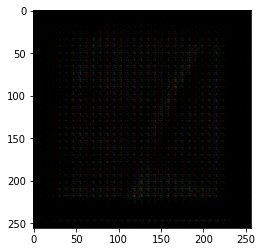

In [24]:
plt.imshow(np.transpose(netG(l_res_cuda)[0].cpu().detach().numpy()))
#h_res.shape

In [25]:
netG(l_res_cuda)[0]

tensor([[[-0.0420, -0.1305, -0.1636,  ..., -0.1709, -0.2173, -0.0910],
         [-0.2222, -0.2234, -0.1754,  ..., -0.1962, -0.0863, -0.1689],
         [-0.1249, -0.2049, -0.2840,  ..., -0.1626, -0.2272, -0.1351],
         ...,
         [-0.1302, -0.1946,  0.0205,  ..., -0.1854, -0.0999, -0.2151],
         [-0.1081, -0.1883, -0.1904,  ..., -0.2282, -0.3596, -0.1942],
         [-0.0997, -0.0750, -0.0819,  ..., -0.1614, -0.1641, -0.0884]],

        [[-0.0720, -0.1402, -0.0756,  ..., -0.1545, -0.0808, -0.0996],
         [-0.0567, -0.2119, -0.1731,  ..., -0.1743, -0.1712, -0.1527],
         [-0.1981, -0.2068, -0.2257,  ..., -0.1529, -0.1665, -0.1717],
         ...,
         [-0.0631, -0.1410, -0.1533,  ..., -0.1896, -0.2227, -0.1802],
         [-0.1655, -0.1393, -0.1660,  ..., -0.1813, -0.2154, -0.1674],
         [-0.0609, -0.1285, -0.0822,  ..., -0.1759, -0.1415, -0.0924]],

        [[-0.0613, -0.0698, -0.1332,  ..., -0.0874, -0.1723, -0.0846],
         [-0.1573, -0.2423, -0.2621,  ..., -0

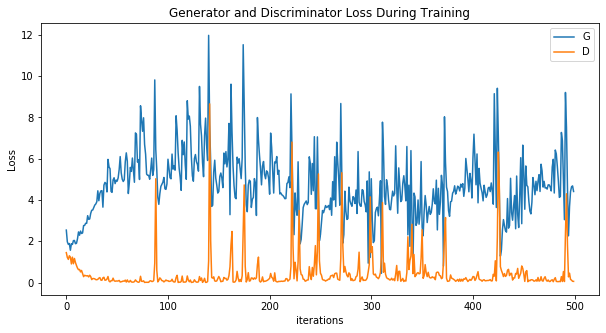

In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

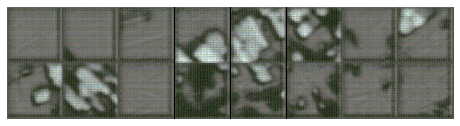

In [27]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

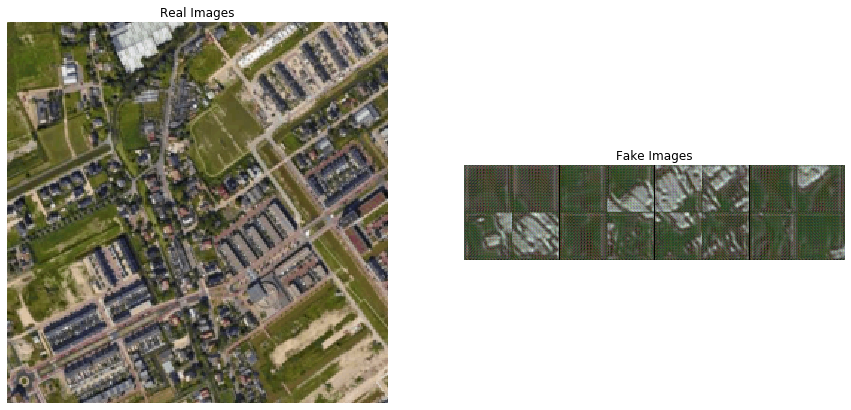

In [29]:
# Grab a batch of real images from the dataloader
(plc, real_batch) = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
img_list[0].shape